# Libraries and Data Import
Also have a quick look at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(rc={'figure.facecolor': "white"})
repository_directory = "../"

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, cross_val_score
import os
import sys
# add .. to path so python can find our script in ../src/data/
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data


# Data Import

In [3]:
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = df_source.copy()

In [4]:
# df_source[df_source.isna().any(axis=1)]
df_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462966 entries, 0 to 463088
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  462966 non-null  datetime64[ns]
 1   serial_number         462966 non-null  object        
 2   model                 462966 non-null  object        
 3   failure               462966 non-null  int64         
 4   smart_1_normalized    462966 non-null  float64       
 5   smart_1_raw           462966 non-null  float64       
 6   smart_3_normalized    462966 non-null  float64       
 7   smart_4_raw           462966 non-null  float64       
 8   smart_5_normalized    462966 non-null  float64       
 9   smart_5_raw           462966 non-null  float64       
 10  smart_7_normalized    462966 non-null  float64       
 11  smart_7_raw           462966 non-null  float64       
 12  smart_9_normalized    462966 non-null  float64       
 13 

Check for duplicates:

In [5]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


Show one of the duplicates:

In [6]:
df_source.query("serial_number == @tmp[0]").sort_values(by="date", ascending=False).head(6)

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
298155,2021-10-11,Z302SQFX,ST4000DM000,1,111.0,32839264.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53663.0,6.820128e+10,2.930498e+11,2021-10-11,0
298238,2021-10-11,Z302SQFX,ST4000DM000,1,111.0,32839264.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53663.0,6.820128e+10,2.930498e+11,2021-10-11,0
298066,2021-10-10,Z302SQFX,ST4000DM000,0,119.0,234015344.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53639.0,6.818406e+10,2.929217e+11,2021-10-11,1
297974,2021-10-09,Z302SQFX,ST4000DM000,0,111.0,36343000.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53615.0,6.816239e+10,2.928034e+11,2021-10-11,2
297884,2021-10-08,Z302SQFX,ST4000DM000,0,112.0,48097320.0,92.0,9.0,100.0,184.0,...,99.0,232.0,99.0,232.0,0.0,53590.0,6.814426e+10,2.927009e+11,2021-10-11,3
297788,2021-10-07,Z302SQFX,ST4000DM000,0,119.0,213927912.0,92.0,9.0,100.0,184.0,...,99.0,248.0,99.0,248.0,0.0,53565.0,6.812408e+10,2.925268e+11,2021-10-11,4


Set up the classification column (1 for failure in 30 days and 0 for failure beyond 30 days):

In [7]:
days_before_failure = 30
def get_classification(countdown, days=days_before_failure):
    if countdown <= days:
        return 1
    return 0

df["failure_in_30_days"] = df["countdown"].apply(get_classification)
df.head(3)

,index,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,...,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown,failure_in_30_days
0,0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,...,0.0,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50,0
1,1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,...,16.0,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255,0
2,2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,...,16.0,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252,0


# Some useful functions and lists

In [8]:
# specify commonly used column names
column_name_all = list(df.columns)
column_name_basic = column_name_all[:4] + column_name_all[-3:]
column_name_smart_all = [c for c in column_name_all if "smart_" in c ]
column_name_smart_raw = [c for c in column_name_smart_all if "_raw" in c ]
column_name_smart_normalized = [c for c in column_name_smart_all if "normalized" in c ]
#column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
#column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_power_on_time = [9]
key_smart_group = [5, 183, 184, 187]

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {3   : "spin_up_time",
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  10  : "spin_retry_count",
                  183 : "downshift_error_count", #  another possible meaning is: Runtime Bad Block
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  190 : "temperature_special", # vendor-dependent
                  194 : "temperature",
                  196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  201 : "software_read_error_count", 
                  231 : "expected_life_left"
    }
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : int(x)/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1, inplace=True)
    return df

Limit ourselves to some columns only:

In [9]:
# choose smart and set up the column name 
key_smart = [5, 183, 184, 187]
column_name_smart = ["smart_" + str(i) + "_" + "raw" for i in key_smart]
column_name = column_name_basic + column_name_smart
print("Columns chosen for the dataframe:\n", column_name)

df = keep_some_smart_column_for_dataframe(df, smart_to_keep=key_smart, raw_or_normalized="raw")
df.head(3)

Columns chosen for the dataframe:
 ['index', 'date', 'serial_number', 'model', 'date_failure', 'countdown', 'failure_in_30_days', 'smart_5_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw']


,index,date,serial_number,model,failure,date_failure,countdown,failure_in_30_days,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
0,0,2020-09-18,Z304JG86,ST4000DM000,0,2020-11-07,50,0,0.0,0.0,0.0,0.0
1,1,2020-09-18,S301GMGZ,ST4000DM000,0,2021-05-31,255,0,0.0,5.0,0.0,5.0
2,2,2020-09-18,S300YQTN,ST4000DM000,0,2021-05-28,252,0,0.0,0.0,0.0,1.0


## Train-Test Split

We will split the data according to serial numbers

In [35]:
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df["serial_number"].unique(), df["serial_number"].unique(), test_size=0.2, random_state=RSEED)
serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

df_train = df[ df["serial_number"].isin(serial_number_train)]
df_train = df_train.drop("index", axis=1).reset_index(drop=True)
y_train = df_train["failure_in_30_days"]
X_train = df_train[column_name_smart]

df_test = df[ df["serial_number"].isin(serial_number_test)]
df_test = df_test.drop("index", axis=1).reset_index(drop=True)
y_test = df_test["failure_in_30_days"]
X_test = df_test[column_name_smart]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

failed_days = df_train.query("failure == 1")["failure"].count()
healthy_days = df_train.query("failure == 0")["failure"].count()
print("number of days for failed/healthy drive in train:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),"%")
failed_days = df_test.query("failure == 1")["failure"].count()
healthy_days = df_test.query("failure == 0")["failure"].count()
print("number of days for failed/healthy drive in test:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),'%')

failed_days = df_train.query("failure_in_30_days == 1")["failure"].count()
healthy_days = df_train.query("failure_in_30_days == 0")["failure"].count()
print("number of days for fail-in-30 / not-fail-in-30 in train:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),"%")
failed_days = df_test.query("failure_in_30_days == 1")["failure"].count()
healthy_days = df_test.query("failure_in_30_days == 0")["failure"].count()
print("number of days for fail-in-30 / not-fail-in-30 in test:", failed_days, "/", healthy_days, '=', (failed_days/healthy_days*100).round(4),'%')

number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122
number of days for failed/healthy drive in train: 486 / 373101 = 0.1303 %
number of days for failed/healthy drive in test: 122 / 89255 = 0.1367 %
number of days for fail-in-30 / not-fail-in-30 in train: 15071 / 358516 = 4.2037 %
number of days for fail-in-30 / not-fail-in-30 in test: 3772 / 85605 = 4.4063 %


In [11]:
df_train.head(3)

,date,serial_number,model,failure,date_failure,countdown,failure_in_30_days,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
0,2020-09-18,Z304JG86,ST4000DM000,0,2020-11-07,50,0,0.0,0.0,0.0,0.0
1,2020-09-18,S300YQTN,ST4000DM000,0,2021-05-28,252,0,0.0,0.0,0.0,1.0
2,2020-09-18,Z302T8AB,ST4000DM000,0,2020-12-04,77,0,0.0,0.0,0.0,0.0


Plot smart states vs countdown, using mean:

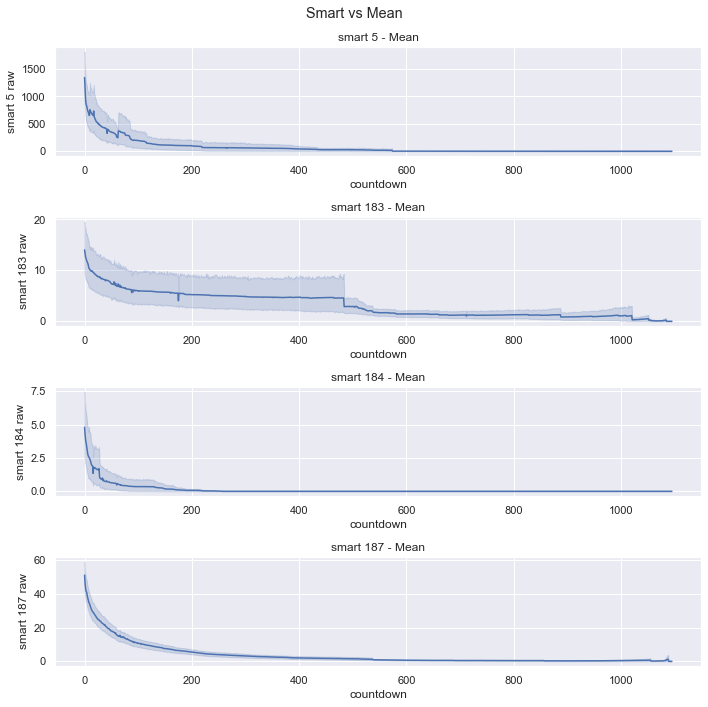

In [12]:
fig, axes = plt.subplots(4,1,figsize=(10, 10))
fig.suptitle("Smart vs Mean")


for i, col in enumerate([name for name in df_train.columns if "smart" in name]):
    sns.lineplot(data=df_train, x="countdown", y=col, estimator="mean", ax=axes[i])
    number = col.split("smart_")[1].split("_")[0]
    axes[i].set_title(f"smart {number} - Mean")
    axes[i].set_ylabel(f"smart {number} raw")
fig.tight_layout()

plt.show()


Plot smart states vs countdown, using medain:

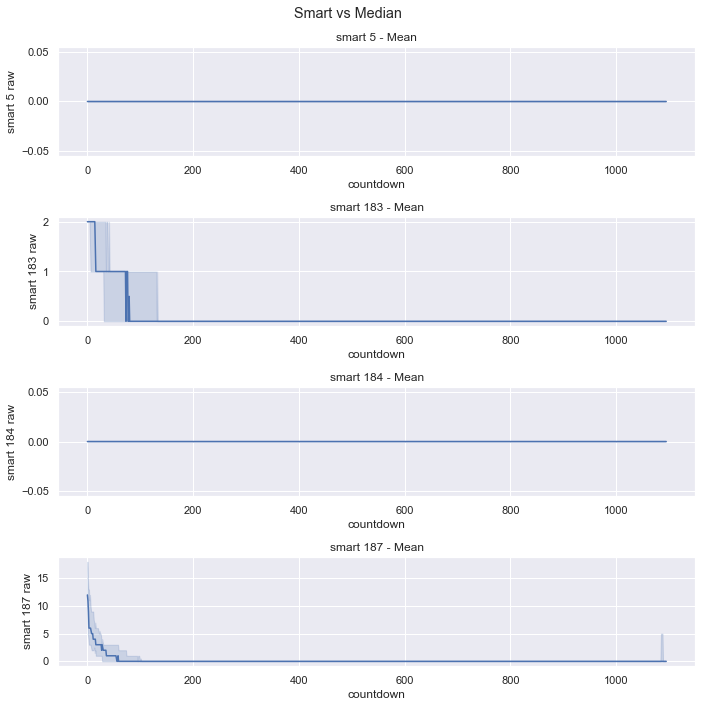

In [13]:
fig, axes = plt.subplots(4,1,figsize=(10, 10))
fig.suptitle("Smart vs Median")


for i, col in enumerate([name for name in df_train.columns if "smart" in name]):
    sns.lineplot(data=df_train, x="countdown", y=col, estimator=np.median, ax=axes[i])
    number = col.split("smart_")[1].split("_")[0]
    axes[i].set_title(f"smart {number} - Mean")
    axes[i].set_ylabel(f"smart {number} raw")
fig.tight_layout()

plt.show()

Initiate the dictionary to store scores/metrics for various models:

In [14]:
performance = dict()

## Baseline Model

In [15]:
def baseline_failure_prediction(features, min_conditions=3):
    s5r = features["smart_5_raw"]
    s183r = features["smart_183_raw"]
    s184r = features["smart_184_raw"]
    s187r = features["smart_187_raw"]
    #if s5r >= 1.0 and s183r >= 5 and s184r >= 1 and s187r >= 20:
    if sum([s5r >= 1.0, s183r >= 1, s184r >= 1, s187r >= 2]) >= min_conditions:
        return 1
    return 0

make predictions on train and test data using the baseline model, and then evaluate the metrics:

In [16]:
y_train_pred = X_train.apply(baseline_failure_prediction, axis=1)
y_test_pred = X_test.apply(baseline_failure_prediction, axis=1)

Define the function for showing results of a model:

In [17]:
def evaluate_metrics(model_name, y_train, y_train_pred, y_test, y_test_pred):

    performance[model_name] = dict()

    print("=======================================")
    print("# For train data:")
    f2 = fbeta_score(y_train, y_train_pred, beta=2)
    print("  f2 score:", f2.round(4))
    print(classification_report(y_train, y_train_pred))
    
    print("=======================================")
    print("# For test data:")
    f2 = fbeta_score(y_test, y_test_pred, beta=2)
    print("  f2 score:", f2.round(4))
    print(classification_report(y_test, y_test_pred))

    performance[model_name]["f2"] = f2


    cm = confusion_matrix(y_train, y_train_pred)

    fig, axes = plt.subplots(2,2,figsize=(10, 10))
    fig.suptitle("Confusion Matrix")
    sns.heatmap(np.log10(cm), annot=True, ax=axes[0,0])
    axes[0,0].set_title("Train (log scale)")
    axes[0,0].set_ylabel("Truth")
    axes[0,0].set_xlabel("Prediction")

    sns.heatmap(cm, annot=True, ax=axes[0,1])
    axes[0,1].set_title("Train")
    axes[0,1].set_ylabel("Truth")
    axes[0,1].set_xlabel("Prediction")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(np.log10(cm), annot=True, ax=axes[1,0])
    axes[1,0].set_title("Test (log scale)")
    axes[1,0].set_ylabel("Truth")
    axes[1,0].set_xlabel("Prediction")

    sns.heatmap(cm, annot=True, ax=axes[1,1])
    axes[1,1].set_title("Test")
    axes[1,1].set_ylabel("Truth")
    axes[1,1].set_xlabel("Prediction")

    fig.tight_layout()
    plt.show()

    performance[model_name]["confusion_matrix"] = cm

# For train data:
  f2 score: 0.2162
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    358516
           1       0.26      0.21      0.23     15071

    accuracy                           0.94    373587
   macro avg       0.61      0.59      0.60    373587
weighted avg       0.94      0.94      0.94    373587

# For test data:
  f2 score: 0.1577
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     85605
           1       0.42      0.14      0.21      3772

    accuracy                           0.96     89377
   macro avg       0.69      0.56      0.59     89377
weighted avg       0.94      0.96      0.94     89377



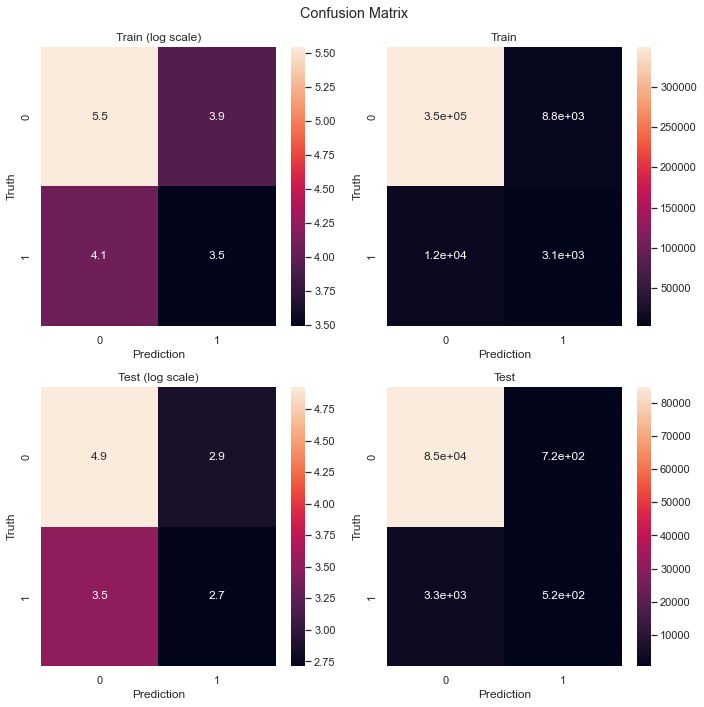

In [18]:
evaluate_metrics("baseline", y_train, y_train_pred, y_test, y_test_pred)

# Creating scaled data

We could observe the data and decide which scaler to use:

In [20]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,373587.0,93.930185,1286.074903,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,373587.0,4.055725,30.096026,0.0,0.0,0.0,2.0,720.0
smart_184_raw,373587.0,0.169190,4.380564,0.0,0.0,0.0,0.0,340.0
smart_187_raw,373587.0,4.983632,21.676303,0.0,0.0,0.0,0.0,596.0


It looks like a log transformation would be nice for all of the smart features.

In [25]:
#cols = X_train.columns
#cols_smart = [c for c in cols if "smart_" in c ]
#cols_nonsmart = [c for c in cols if not "smart_" in c ]
X_train_log = X_train.apply(lambda x : np.log10(x+1))
#X_train_log = pd.concat([X_train[cols_nonsmart], X_train_log], axis=1)
X_test_log = X_test.apply(lambda x : np.log10(x+1))
#X_test_log = pd.concat([X_test[cols_nonsmart], X_test_log], axis=1)

Now we can have a look at the distribution again at the transformed data

In [26]:
X_train_log.describe()

,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
count,373587.000000,373587.000000,373587.000000,373587.000000
mean,0.108280,0.225670,0.006324,0.241463
std,0.526352,0.410721,0.093532,0.492106
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.477121,0.000000,0.000000
max,4.816168,2.857935,2.532754,2.775974


Perform scaling with Normalizer

In [27]:
scaler = StandardScaler()

X_train_log_scaled = pd.DataFrame(scaler.fit_transform(X_train_log), columns=cols_smart)
#X_train_log_scaled = pd.concat([X_train_log[cols_nonsmart], X_train_log_scaled], axis=1)

X_test_log_scaled = pd.DataFrame(scaler.fit_transform(X_test_log), columns=cols_smart)
#X_test_log_scaled = pd.concat([X_test_log[cols_nonsmart], X_test_log_scaled], axis=1)


In [28]:
X_train_log_scaled.describe()

,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
count,3.735870e+05,3.735870e+05,3.735870e+05,3.735870e+05
mean,5.355883e-17,-1.229419e-16,-3.834325e-17,-1.704145e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.057173e-01,-5.494497e-01,-6.761229e-02,-4.906731e-01
25%,-2.057173e-01,-5.494497e-01,-6.761229e-02,-4.906731e-01
50%,-2.057173e-01,-5.494497e-01,-6.761229e-02,-4.906731e-01
75%,-2.057173e-01,6.122194e-01,-6.761229e-02,-4.906731e-01
max,8.944383e+00,6.408897e+00,2.701130e+01,5.150346e+00


# Logistic Regression (raw data)

# For train data:
  f2 score: 0.0627
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    358516
           1       0.45      0.05      0.09     15071

    accuracy                           0.96    373587
   macro avg       0.70      0.52      0.54    373587
weighted avg       0.94      0.96      0.94    373587

# For test data:
  f2 score: 0.0431
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     85605
           1       0.23      0.04      0.06      3772

    accuracy                           0.95     89377
   macro avg       0.60      0.52      0.52     89377
weighted avg       0.93      0.95      0.94     89377



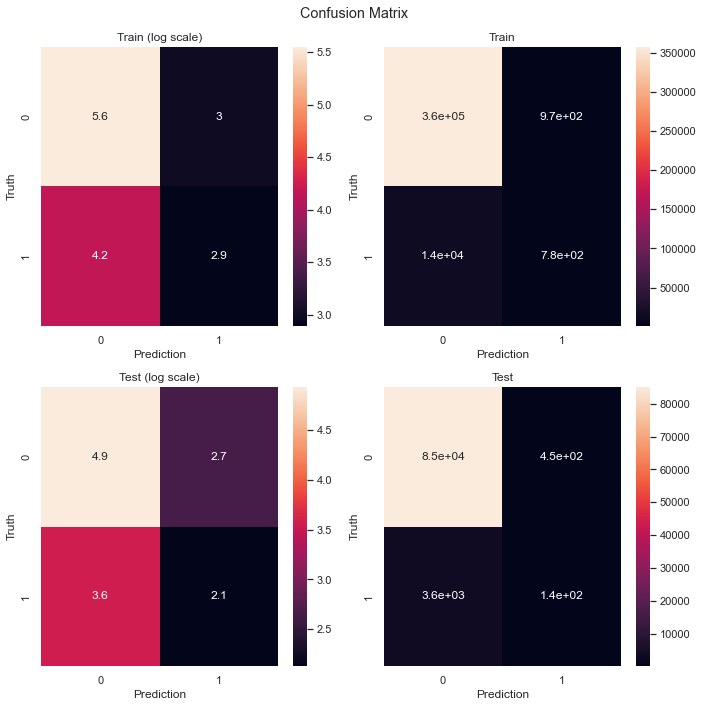

In [52]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)
evaluate_metrics("logistic_regression_raw", y_train, y_train_pred, y_test, y_test_pred)

# Logistic Regression (with log10)

# For train data:
  f2 score: 0.0366
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    358516
           1       0.48      0.03      0.06     15071

    accuracy                           0.96    373587
   macro avg       0.72      0.51      0.52    373587
weighted avg       0.94      0.96      0.94    373587

# For test data:
  f2 score: 0.032
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     85605
           1       0.26      0.03      0.05      3772

    accuracy                           0.96     89377
   macro avg       0.61      0.51      0.51     89377
weighted avg       0.93      0.96      0.94     89377



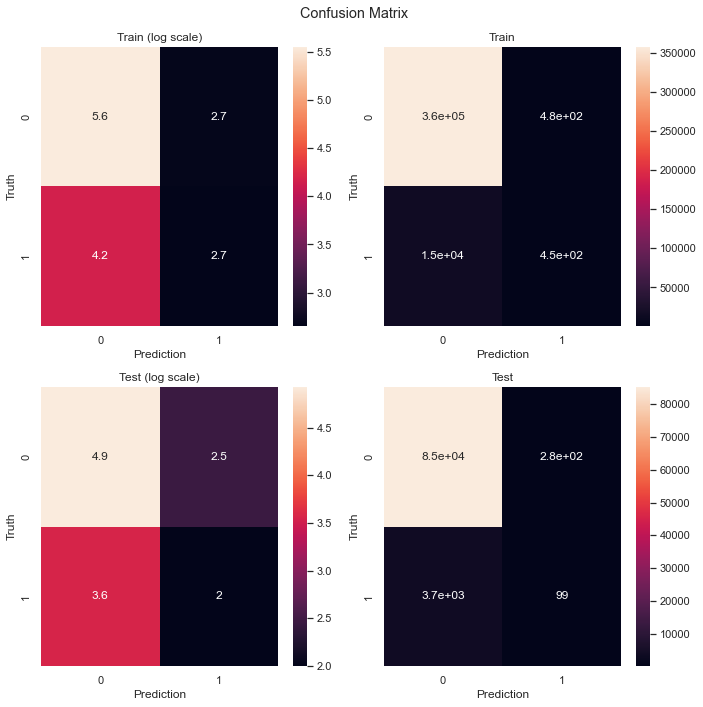

In [53]:
model_lr = LogisticRegression()
model_lr.fit(X_train_log, y_train)
y_train_pred = model_lr.predict(X_train_log)
y_test_pred = model_lr.predict(X_test_log)
evaluate_metrics("logistic_regression_log", y_train, y_train_pred, y_test, y_test_pred)

# Logistic Regression (with log10 and scaling)

# For train data:
  f2 score: 0.0366
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    358516
           1       0.48      0.03      0.06     15071

    accuracy                           0.96    373587
   macro avg       0.72      0.51      0.52    373587
weighted avg       0.94      0.96      0.94    373587

# For test data:
  f2 score: 0.0435
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     85605
           1       0.25      0.04      0.06      3772

    accuracy                           0.95     89377
   macro avg       0.60      0.52      0.52     89377
weighted avg       0.93      0.95      0.94     89377



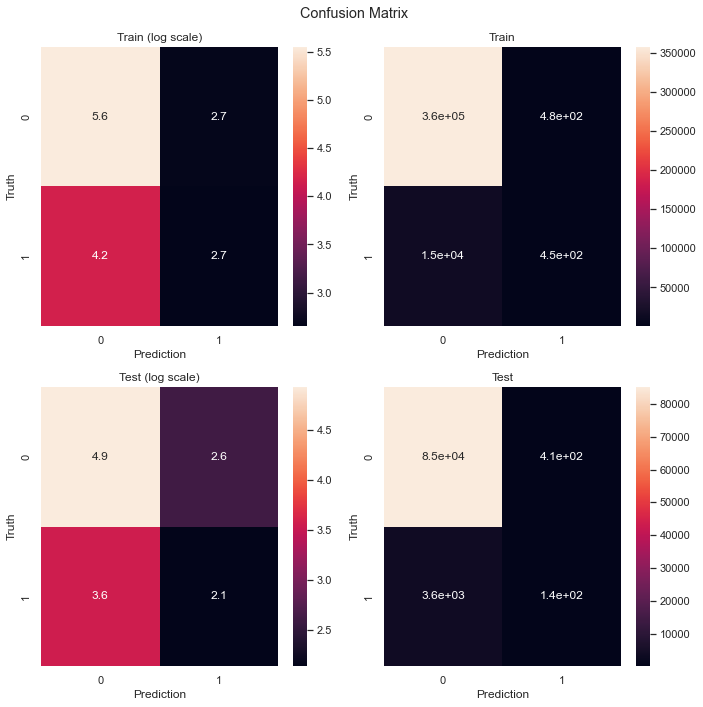

In [54]:
model_lr = LogisticRegression()
model_lr.fit(X_train_log_scaled, y_train)
y_train_pred = model_lr.predict(X_train_log_scaled)
y_test_pred = model_lr.predict(X_test_log_scaled)
evaluate_metrics("logistic_regression_log10_scaled", y_train, y_train_pred, y_test, y_test_pred)

# Decision Tree

# For train data:
  f2 score: 0.2071
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    358516
           1       0.77      0.18      0.29     15071

    accuracy                           0.96    373587
   macro avg       0.87      0.59      0.63    373587
weighted avg       0.96      0.96      0.95    373587

# For test data:
  f2 score: 0.1042
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85605
           1       0.17      0.09      0.12      3772

    accuracy                           0.94     89377
   macro avg       0.57      0.54      0.55     89377
weighted avg       0.93      0.94      0.93     89377



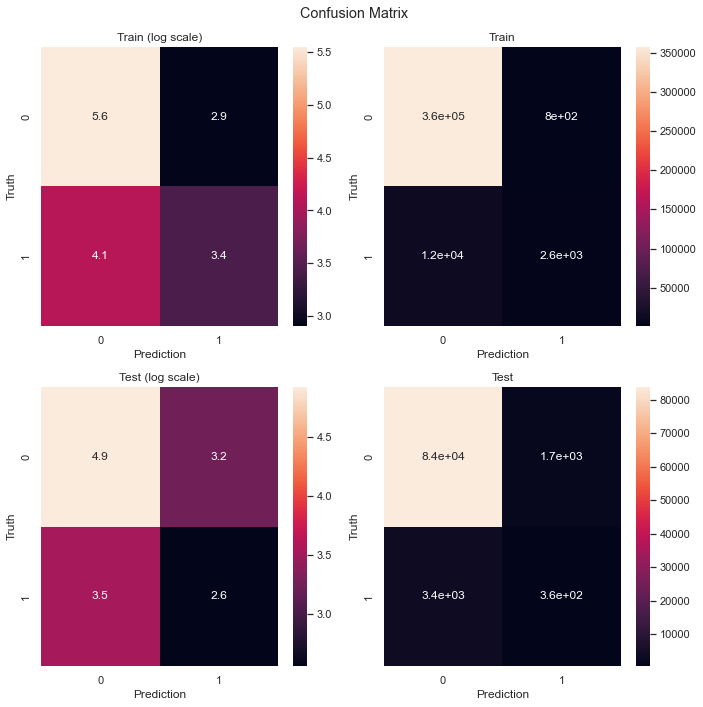

In [55]:
model_dt = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=50)
model_dt.fit(X_train, y_train)
y_train_pred = model_dt.predict(X_train)
y_test_pred = model_dt.predict(X_test)
evaluate_metrics("decision_tree", y_train, y_train_pred, y_test, y_test_pred)